In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import joblib
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_absolute_error

In [38]:
def load_data(url):
    df = pd.read_csv(url)
    return df
df = load_data("C:/Users/Sameer/Internee/Data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## EDA

In [39]:
#univariate statistics
def univariate_stats(df):
    df_output = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'Numeric', 'Mode', 'Mean', 'Min', '25%', 'Median',
                                     '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    for col in df:
        count = df[col].count()
        missing = df[col].isnull().sum()
        unique = df[col].nunique()
        dtype = df[col].dtype
        mode = df[col].mode().values[0] 
        if pd.api.types.is_numeric_dtype(df[col]):
            mean = df[col].mean() 
            min = df[col].min() 
            quantile25 = df[col].quantile(0.25) 
            median = df[col].median()
            quartile75 = df[col].quantile(0.75)
            max_val = df[col].max() 
            std = df[col].std()
            skew = df[col].skew()
            kurt = df[col].kurt()
            df_output.loc[col] = [count, missing, unique, dtype,pd.api.types.is_numeric_dtype(df[col]),mode,
                                  mean, min,quantile25, median, quartile75,max_val,std,skew,kurt]
        else:
            df_output.loc[col] = [count, missing, unique, dtype,pd.api.types.is_numeric_dtype(df[col]),mode,
                                  '-','-','-','-','-','-','-','-','-']
    return df_output.sort_values(by = ['Numeric', 'Skew', 'Unique'], ascending=False)

univariate_stats(df)

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
charges,1338,0,1337,float64,True,1639.5631,13270.422265,1121.8739,4740.28715,9382.033,16639.912515,63770.42801,12110.011237,1.51588,1.606299
children,1338,0,6,int64,True,0,1.094918,0,0.0,1.0,2.0,5,1.205493,0.93838,0.202454
bmi,1338,0,548,float64,True,32.3,30.663397,15.96,26.29625,30.4,34.69375,53.13,6.098187,0.284047,-0.050732
age,1338,0,47,int64,True,18,39.207025,18,27.0,39.0,51.0,64,14.04996,0.055673,-1.245088
region,1338,0,4,object,False,southeast,-,-,-,-,-,-,-,-,-
sex,1338,0,2,object,False,male,-,-,-,-,-,-,-,-,-
smoker,1338,0,2,object,False,no,-,-,-,-,-,-,-,-,-


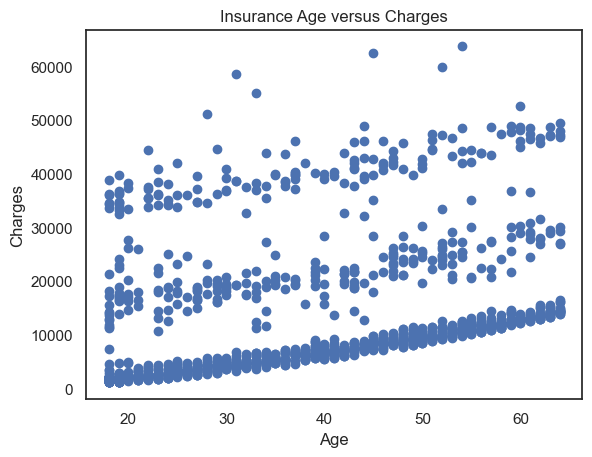

In [40]:
plt.scatter(df.age, df.charges)
plt.title("Insurance Age versus Charges")
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()

In [41]:
df_smoker = df[df['smoker'] == 'yes']
df_nonsmoker = df[df['smoker'] == 'no']
df_smoker

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
11,62,female,26.290,0,yes,southeast,27808.72510
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
...,...,...,...,...,...,...,...
1313,19,female,34.700,2,yes,southwest,36397.57600
1314,30,female,23.655,3,yes,northwest,18765.87545
1321,62,male,26.695,0,yes,northeast,28101.33305
1323,42,female,40.370,2,yes,southeast,43896.37630


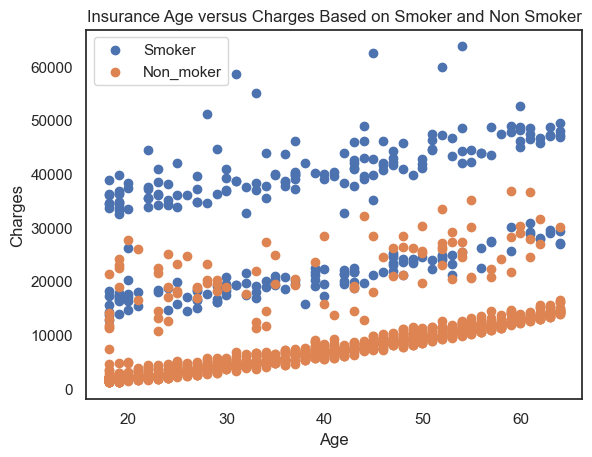

In [42]:
plt.scatter(df_smoker.age, df_smoker.charges, label = 'Smoker')
plt.scatter(df_nonsmoker.age, df_nonsmoker.charges, label = 'Non_moker')
plt.title("Insurance Age versus Charges Based on Smoker and Non Smoker")
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend()
plt.show()

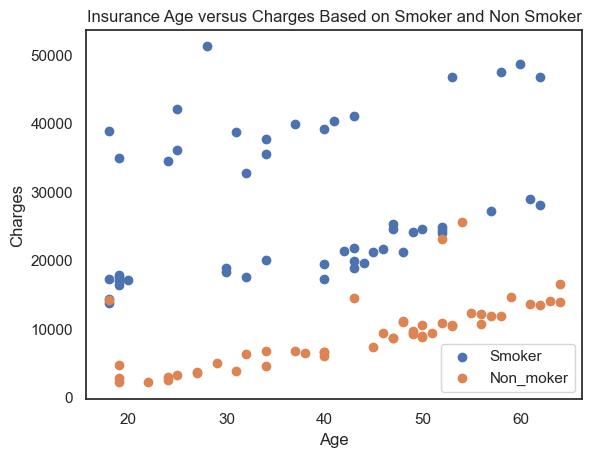

In [43]:
df_smoker_reduce = df_smoker.sample(50)
df_nonsmoker_reduce = df_nonsmoker.sample(50)

plt.scatter(df_smoker_reduce.age, df_smoker_reduce.charges, label = 'Smoker')
plt.scatter(df_nonsmoker_reduce.age, df_nonsmoker_reduce.charges, label = 'Non_moker')
plt.title("Insurance Age versus Charges Based on Smoker and Non Smoker")
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend()
plt.show()

In [44]:
def anova(df, feature, label):
    groups = df[feature].unique()
    df_grouped = df.groupby(feature)
    grouped_labels = []
    for group in groups:
        g_list = df_grouped.get_group(group)
        grouped_labels.append(g_list[label])
    return stats.f_oneway(*grouped_labels)

In [45]:
def heteroscedasticity(df, feature, label):
    formula = f"{label}~{feature}"
    model = ols(formula=formula, data=df).fit()
    
    output_df = pd.DataFrame(columns=['LM stats', 'LM p', 'F stat', 'F stat p'])
    try:
        white_test = het_white(model.resid, model.model.exog)
        output_df.loc['White'] = white_test
    except:
        print("Unable to run White test of heteroscedasticity")
    breuschpagan_test = het_breuschpagan(model.resid, model.model.exog)
    output_df.loc['Br-pa'] = breuschpagan_test
    return output_df.round(3)

def scatter(feature,label):
    m, b, r, p, err = stats.linregress(feature, label)
    
    textstr = 'y = ' + str(round(m,2)) + 'x + ' +  str(round(b,2)) + ' \n'
    textstr += 'r2 = ' + str(round(r**2, 2)) + '\n'
    textstr += 'p = ' + str(round(p,2)) + '\n'
    textstr += str(feature.name) + " skew = " + str(round(feature.skew(),2)) + '\n'
    textstr += str(label.name) + " skew = " + str(round(label.skew(),2))+ '\n'
    textstr += str(heteroscedasticity(pd.DataFrame(label).join(pd.DataFrame(feature)), feature.name, label.name))
    
    sns.set(color_codes = True)
    ax = sns.jointplot(x = feature, y = label, kind = 'reg');
    ax.fig.text(1, 0.114, textstr, fontsize=12, transform= plt.gcf().transFigure)
    plt.show()

In [46]:
def bar_chart(df, feature, label):    
    # Prepare data for statistical tests
    groups = df[feature].unique()
    df_grouped = df.groupby(feature)
    grouped_labels = [df_grouped.get_group(group)[label].values for group in groups]
    
    one_way = stats.f_oneway(*grouped_labels)

    # T-tests
    ttests = []
    for i, group1 in enumerate(groups):
        for group2 in groups[i+1:]:
            g1 = df[df[feature] == group1][label]
            g2 = df[df[feature] == group2][label]
            
            if len(g1) < 2 or len(g2) < 2:
                print(f"'{group1}' n = {len(g1)} '{group2}' n = {len(g2)}; no T-test performed")
            else:
                t, p = stats.ttest_ind(g1, g2)
                ttests.append([group1, group2, t, p])

    # Bonferroni correction
    if len(ttests) > 0:
        threshold = 0.05 / len(ttests)
    else:
        threshold = 0.05
        
    # Prepare text for statistical results
    textstr = 'ANOVA\n'
    textstr += f'F: {one_way.statistic:.4f}\n'
    textstr += f'P: {one_way.pvalue:.4f}\n'
    textstr += 'Sig. Comparisons (Bonferroni)\n'

    for group1, group2, t, p in ttests:
        if p <= threshold:
            textstr += f'{group1}-{group2}: t={t:.4f}, p={p:.4f}\n'
    
    ax = sns.barplot(x = df[feature], y = df[label])
    ax.text(1, 0.1, textstr, fontsize=12, transform=plt.gcf().transFigure)
    plt.xticks(rotation=90)
    plt.show()


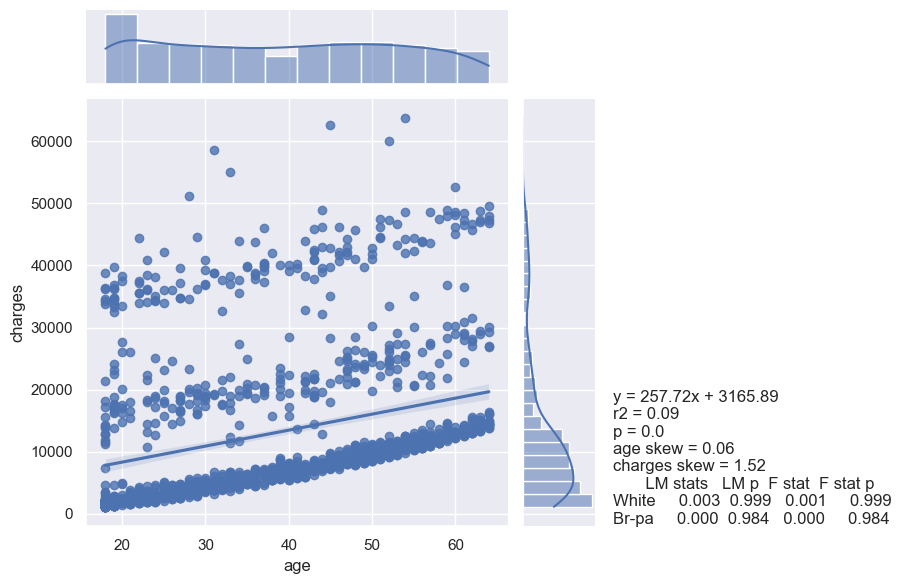

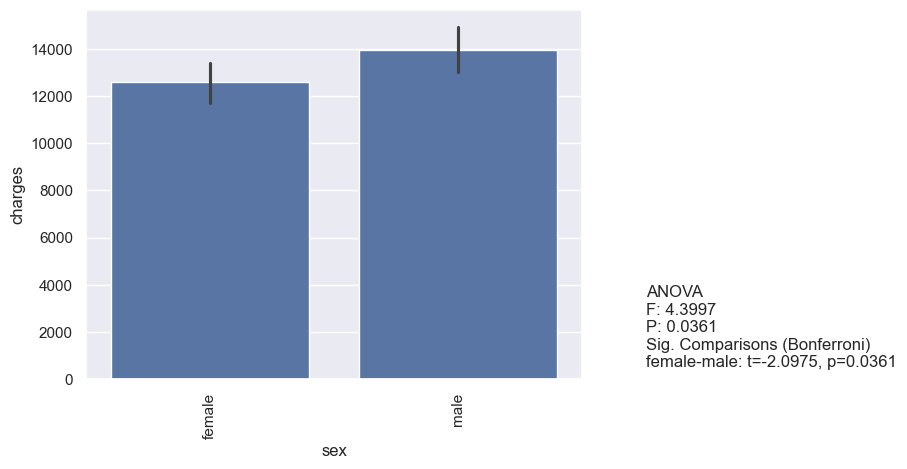

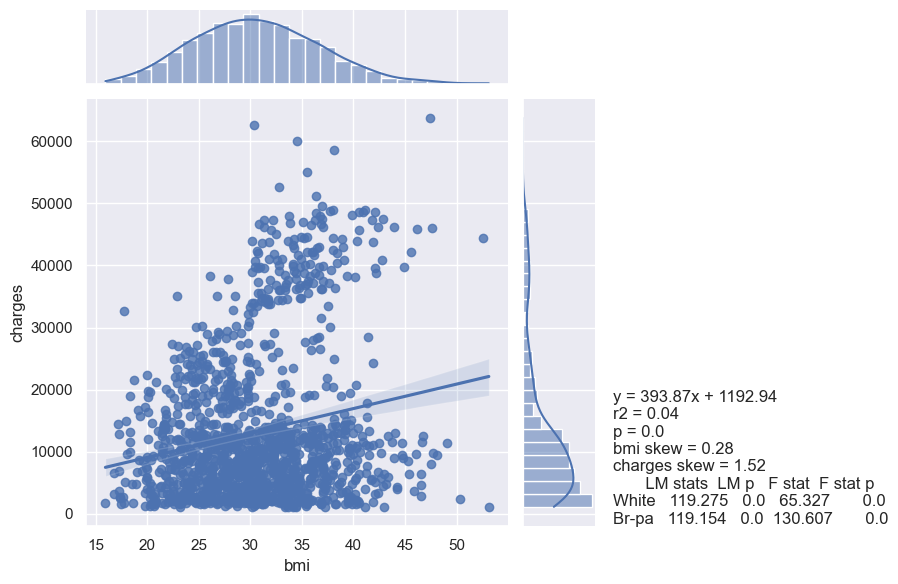

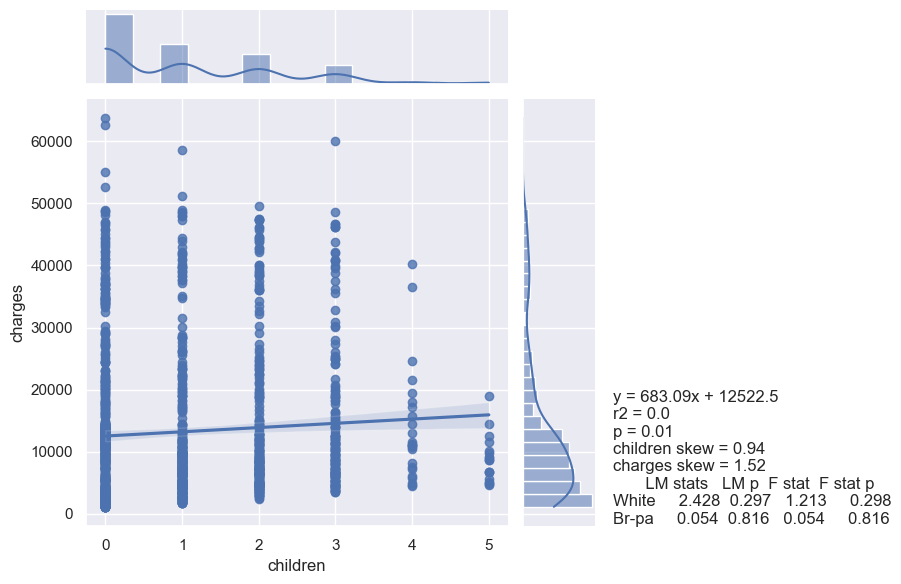

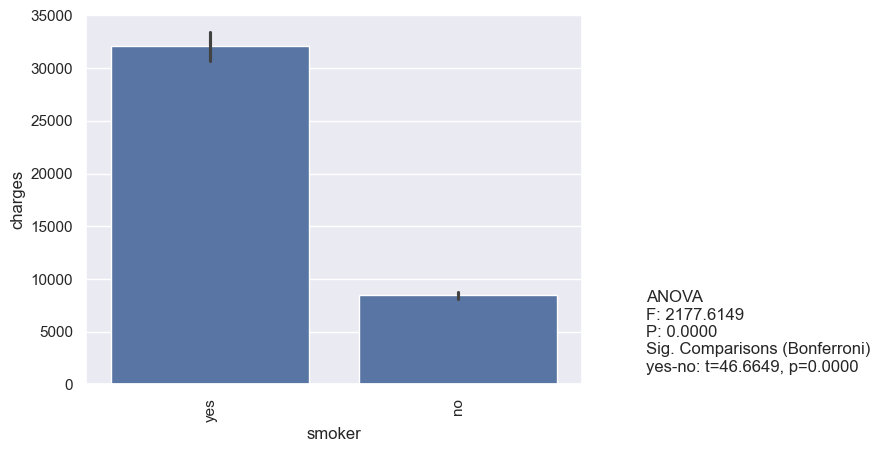

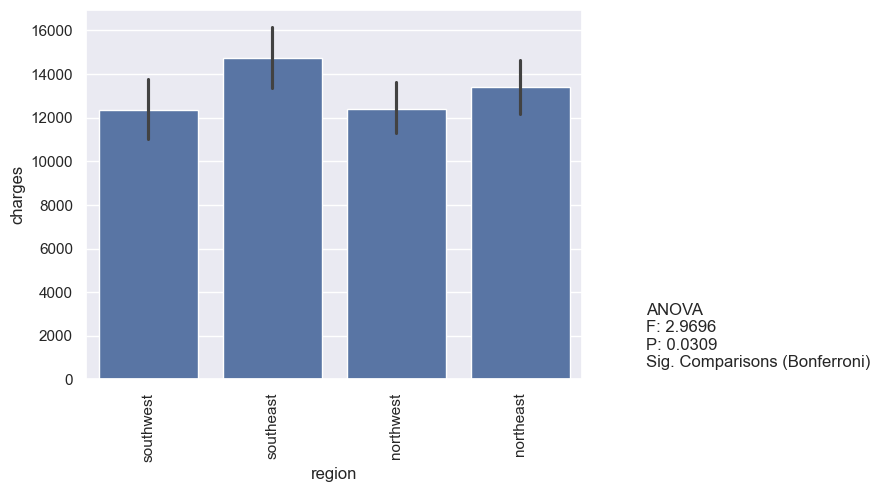

,Stat,+/-,Effect size,p-value
age,r,1.0,0.299,0.000000
bmi,r,1.0,0.198,0.000000
children,r,1.0,0.068,0.012852
smoker,F,,2177.615,0.000000
sex,F,,4.400,0.036133
region,F,,2.970,0.030893


In [47]:
#BiVariate: Numeric to Numeric: COrelation
#BiVariate: Numeric to Categorical: one-way ANOVA (3+ groups) or t-test (2 groups)
#BiVariate: Categorical to Categorical: Chi-square
def bivariate_stats(df, label):
    output_df = pd.DataFrame(columns=['Stat', '+/-', 'Effect size', 'p-value'])
    for col in df:
        if not col == label:
            if df[col].isnull().sum() == 0 :
                if pd.api.types.is_numeric_dtype(df[col]):
                    r, p = stats.pearsonr(df[label] , df[col])
                    output_df.loc[col] = ['r', np.sign(r), abs(round(r,3)), round(p,6)]
                    scatter(df[col], df[label])
                else:
                    F, p = anova(df[[col, label]], col, label)
                    output_df.loc[col] = ['F', '', round(F,3), round(p,6)]
                    bar_chart(df, col, label)
            else:
                output_df.loc[col] = [np.nan, np.nan, np.nan, 'nulls']
    return output_df.sort_values(by=['Stat', 'Effect size'], ascending=False)
bivariate_stats(df, 'charges')

In [48]:
fig = px.scatter_3d(df, x='age', y='charges', z='bmi')
fig.show()

In [49]:
fig = px.scatter_3d(df, x='age', y='charges', z='bmi', color='smoker')
fig.show()

In [50]:
fig = px.scatter_3d(df, x='age', y='charges', z='bmi', color='smoker', symbol='sex')
fig.show()

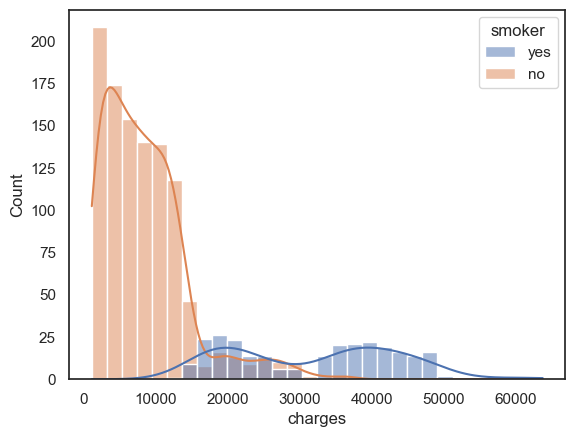

In [51]:
sns.set_style('white')
sns.histplot(data=df, x = 'charges', hue = 'smoker', kde = True);

## MLR

In [52]:
label = 'charges'
y = df.charges
X = df[['age', 'bmi', 'children']].assign(const=1)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     60.69
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           8.80e-37
Time:                        16:46:20   Log-Likelihood:                -14392.
No. Observations:                1338   AIC:                         2.879e+04
Df Residuals:                    1334   BIC:                         2.881e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          239.9945     22.289     10.767      0.0

In [53]:
df_dum = df
for col in df_dum:
    if not pd.api.types.is_numeric_dtype(df_dum[col]):
        df_dum = pd.get_dummies(df_dum, columns=[col], prefix=col, drop_first=True)
df_dum = df_dum.astype(int)
df_dum.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27,0,16884,0,1,0,0,1
1,18,33,1,1725,1,0,0,1,0
2,28,33,3,4449,1,0,0,1,0
3,33,22,0,21984,1,0,1,0,0
4,32,28,0,3866,1,0,1,0,0


In [54]:
y = df_dum.charges
X = df_dum.drop(columns=[label]).assign(const=1)
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.7
Date:                Sat, 31 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:46:29   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                256.9773     11.898  

In [55]:
df_features = pd.DataFrame({'coef' : results.params, 't' : abs(results.tvalues), 'p' : results.pvalues})
df_features.sort_values(by=['t', 'p'])

,coef,t,p
sex_male,-132.420928,0.397696,6.909185e-01
region_northwest,-346.465325,0.727403,4.671071e-01
region_southwest,-969.570830,2.028255,4.273334e-02
region_southeast,-1042.446733,2.176775,2.967293e-02
children,478.234646,3.470253,5.366165e-04
bmi,337.990463,11.852746,7.037544e-31
const,-11741.987852,12.039515,9.254722e-32
age,256.977287,21.597489,6.543246e-89
smoker_yes,23859.771378,57.744753,0.000000e+00


In [56]:
y = df['charges']
X = df.drop('charges', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

def bin_bmi(X):
    X_ = X.copy()
    X_['bmi_binned'] = pd.cut(X_['bmi'], bins=3, labels=[0, 1, 2])
    return X_

numeric_transformer = Pipeline(steps=[
    ('binner', FunctionTransformer(bin_bmi, validate=False)),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False))
])

categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('binner',
                                                                   FunctionTransformer(func=<function bin_bmi at 0x000002CA24C3CE00>)),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor', LinearRegression())])

In [57]:
y_pred = model.predict(X_test)
print(f"\nR2 Score: {r2_score(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")


R2 Score: 0.800493772099525
MSE: 30503614.310718615


In [58]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Average actual charge: {y_test.mean()}")
print(f"Standard deviation of actual charges: {y_test.std()}")

RMSE: 5523.007723217361
MAE: 4029.0362595932424
Average actual charge: 13594.47488760821
Standard deviation of actual charges: 12388.227954089536


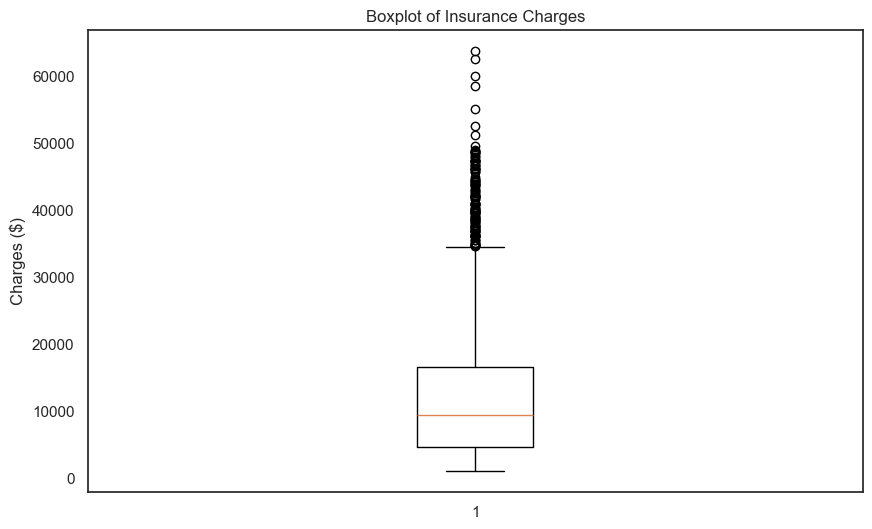

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
1%        1252.972730
5%        1757.753400
25%       4740.287150
50%       9382.033000
75%      16639.912515
95%      41181.827787
99%      48537.480726
max      63770.428010
Name: charges, dtype: float64


In [59]:
plt.figure(figsize=(10,6))
plt.boxplot(df['charges'])
plt.title('Boxplot of Insurance Charges')
plt.ylabel('Charges ($)')
plt.show()

print(df['charges'].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]))

In [60]:
insurance = df

# Log-transform the target variable
insurance['log_charges'] = np.log(insurance['charges'])

# Create a binary feature for high-cost cases
insurance['high_cost'] = (insurance['charges'] > insurance['charges'].quantile(0.95)).astype(int)

X = insurance.drop(['charges', 'log_charges'], axis=1)
y = insurance['log_charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define which columns should be encoded vs scaled
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Create a pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))

print(f"R2 Score: {r2}")
print(f"MAPE: {mape}")

R2 Score: 0.8466674160767298
MAPE: 0.18874940660419293


In [61]:
# Feature importance
feature_importance = rf_pipeline.named_steps['regressor'].feature_importances_
feature_names = (numeric_features + 
                 rf_pipeline.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())

# Create a dataframe of feature importances
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)


Feature Importances:
            feature  importance
4        smoker_yes    0.436814
0               age    0.380505
1               bmi    0.105306
2          children    0.041902
3          sex_male    0.012146
6  region_southeast    0.008910
5  region_northwest    0.007591
7  region_southwest    0.006825


In [23]:
joblib.dump(rf_pipeline, 'insurance_model_pipeline.pkl')

print("Model saved as 'insurance_model_pipeline.pkl'")

Model saved as 'insurance_model_pipeline.pkl'
